# CSS Lab: Social Rank and Hierarchy
Network analysis can be used to examine social status within a community. This lab will use data from the 1995-1997 Teenage Friends and Lifestyle study [MA1997]. This study collected friendship and other data from a group of 50 teenage girls over the course of three years.

## Contents
1. Setup
2. Directed networks
    1. Load and visualize the social network
3. Social status
    1. Minimum violation rankings
    2. Eigenvector centrality
    3. Spring rank
    4. Compare MVR approximations
    5. Analyze friendships

## Setup

In [135]:
%pylab inline
import itertools
import json
import math
import urllib.request
import networkx as nx
import networkx.algorithms as nxalg
import networkx.algorithms.community as nxcom
import networkx.readwrite as nxrw
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as spstats
import visJS2jupyter.visJS_module as vjs
import re
from springrank.SpringRank_tools import SpringRank
from springrank.tools import build_graph_from_adjacency


Populating the interactive namespace from numpy and matplotlib


In [136]:
# Helper functions

def load_social():
    G = nx.DiGraph()
    edges = dict()
    with open("external/facebook-wosn-wall/out.facebook-wosn-wall") as f:
        for row in f:
            if row[0] == "%":
                continue
            try:
                data = [int(x) for x in re.split("\s+", row.strip())]
                source, target, weight, timestamp = data
            except ValueError:
                print(row)
                print(re.split("\s+", row))
                raise
            try:
                edges[(source, target)] += 1
            except KeyError:
                edges[(source, target)] = 1
    for source, target in edges:
        G.add_edge(source, target)
    return G

def load_tfls():
    G = nx.DiGraph()
    with open("external/s50_data/s50-network1.dat") as f:
        for row, row_data in enumerate(f):
            for col, cell_data in enumerate(re.split("\s", row_data.strip())):
                cell_data = float(cell_data)
                if cell_data != 0:
                    G.add_edge(row, col, weight=cell_data, value=cell_data)
    nx.set_node_attributes(G, dict((v, v) for v in G.nodes()), name="label")
    return G


def get_colors():
    phi = (1 + math.sqrt(5)) / 2
    color = []
    for i in range(1, 20):
        theta = phi * i * math.pi * 2
        x = 128 + math.floor(64*math.sin(theta))
        y = 128 + math.floor(64*math.cos(theta))
        color.append((x, x, y))
    return color


def visualize_visjs(
        G, communities=None, colors=None, default_color="192,192,192",
        node_size_field="node_size", layout="spring", scale=500, pos=None,
        groups=None, weight=None, labels=dict(), title="", node_alpha=1.0):
    # Get list of nodes and edges
    nodes = list(G.nodes())
    edges = list(G.edges())
    # Change node shapes for bipartite graph
    if groups is None:
        node_shapes = dict()
        node_sizes = dict()
        node_colors = dict()
    else:
        node_shapes = dict((n, "square") for n in groups)
        node_sizes = dict((n, 15) for n in groups)
        node_colors = dict((n, "192,128,0") for n in groups)
    # Per-node properties
    nodes_dict = dict((n, {
        "id": str(labels.get(n, n)),
        "node_size": node_sizes.get(n, 5),
        "node_shape": node_shapes.get(n, "dot")
        }) for n in nodes)
    # Generate a layout for the nodes
    edge_smooth_enabled = False
    edge_width = 4
    edge_arrow_scale = 2
    if communities is not None and pos is None:
        # Generate initial positions based on community
        phi = 3.14 / len(nodes)
        community_node = []
        # Create list of nodes and their communities
        for i, com in enumerate(sorted(communities, key=lambda x: len(x), reverse=True)):
            for node in com:
                community_node.append((i, node))
        # Sort by community and
        community_node = sorted(community_node)
        # Generate initial position by placing communities around a circle
        pos = dict((d[1], (math.cos(i*phi), math.sin(i*phi))) for i, d in enumerate(community_node))
    if layout == "circle":
        pos = nx.circular_layout(G, scale=scale)
    elif layout == "spring":
        pos = nx.spring_layout(G, k=3/math.sqrt(len(nodes)), scale=scale, pos=pos)
    else:
        edge_smooth_enabled = True
    # Assign position
    for n in nodes:
        nodes_dict[n]["x"] = pos[n][0]
        nodes_dict[n]["y"] = pos[n][1]
    # Calculate bounds for scaling
    x_min = min(pos.values(), key=lambda x: x[0])[0]
    x_max = max(pos.values(), key=lambda x: x[0])[0]
    y_min = min(pos.values(), key=lambda x: x[1])[1]
    y_max = max(pos.values(), key=lambda x: x[1])[1]
    x_range = x_max - x_min
    y_range = y_max - y_min
    max_range = max(x_range, y_range)
    # If we have communities, assign color based on community
    if colors is None:
        colors = ["{},{},{}".format(*c) for c in get_colors()]
    if communities is not None:
        for i, com in enumerate(sorted(communities, key=lambda x: len(x), reverse=True)):
            for node in com:
                try:
                    nodes_dict[node]["color"] = "rgba({},{})".format(colors[i], node_alpha)
                    nodes_dict[node]["color_index"] = i
                except IndexError:
                    nodes_dict[node]["color"] = "rgba({},{})".format(default_color, node_alpha)
    # Update color for bipartite nodes
    for node, node_attr in nodes_dict.items():
        if node in node_colors:
            node_attr["color"] = "rgba({},{})".format(node_colors[node], node_alpha)
    # Map node labels to contiguous ids
    node_map = dict(zip(nodes,range(len(nodes))))
    # Determine edge colors
    edge_colors_idx = {}
    for source, target in edges:
        source_color = nodes_dict[source].get("color_index", None)
        target_color = nodes_dict[target].get("color_index", None)
        if source_color == target_color and source_color is not None:
            edge_colors_idx[(source, target)] = source_color
    edge_colors = dict(
        (e,colors[c])
        for e, c in edge_colors_idx.items() if c < len(colors))
    # Per-edge properties, use contiguous ids to identify nodes
    edge_scale = math.ceil(max_range / 200)
    edges_dict = []
    for source, target, data in G.edges(data=True):
        edge = {
            "source": node_map[source],
            "target": node_map[target],
            "title":'test',
            "color": "rgba({},0.3)".format(edge_colors.get((source,target), default_color)),
            "edge_width_field": "value",
            "value": data.get("value", 1) * edge_scale
        }
        edges_dict.append(edge)
    # Convert nodes dict to node list
    nodes_list = [nodes_dict[n] for n in nodes]
    # Check for directed graph
    if G.__class__ == nx.classes.digraph.DiGraph:
        directed = True
    else:
        directed = False
    # Call visjs
    return vjs.visjs_network(
        nodes_list, edges_dict,
        node_size_field="node_size",
        node_size_multiplier=10.0,
        edge_width_field="value",
        edge_width=edge_width,
        edge_arrow_to=directed,
        edge_arrow_to_scale_factor=edge_arrow_scale,
        edge_smooth_enabled=edge_smooth_enabled,
        edge_smooth_type="curvedCW",
        graph_id=hash(title))


## Social status
When members of a social group can be ordered in terms of social status, it forms a pecking order. Directed network data can be used to uncover an underlying pecking order if it exists. An unreciprocated friendship can be a sign of a difference in social standing. The person who doesn't list the friendship may do so because they have too many friends to list, or because they don't want to list someone unpopular.

### Minimum violation rankings
In a perfect pecking order, friendships would only go from lower-ranked nodes to higher-ranked nodes.
So to find a pecking order, we look for a _minimum-violation ranking_: an ordering with as few links going from high-status to low-status individuals as possible.
Such an ordering may or may not exist.
The more violoations in the MVR, the less heirarchical a group is.
The example below allows you to test different orderings for the number of violations.

In [137]:
# Helper functions 

def scale(x):
    return (x - np.mean(x)) / np.std(x)

def giant_component(G):
    giant_component = sorted(nxalg.weakly_connected_components(G), reverse=True, key=len)[0]
    for v in set(G.nodes()) - giant_component:
        G.remove_node(v)
    return G

def get_spring_rank(G):
    nodes = list(G.nodes())
    A=nx.to_numpy_matrix(G,nodelist=list(nodes))
    rank = dict(zip(nodes, scale(SpringRank(A,alpha=0.0,l0=1.0,l1=1.0))))
    order = dict((elt[0], i) for i, elt in enumerate(sorted(rank.items(), key=lambda x: x[1], reverse=True)))
    return rank, order

def get_eigenvector_rank(G):
    all_nodes = set(G.nodes())
    components = nx.algorithms.components.weakly_connected_components(G)
    rank = dict()
    for c in components:
        H = G.copy()
        H.remove_nodes_from(all_nodes - set(c))
        component_rank = nx.algorithms.centrality.eigenvector_centrality_numpy(H)
        rank.update(component_rank)
    nodes, ranks = zip(*list(rank.items()))
    ranks = -1 * scale(ranks)
    rank = dict(zip(list(nodes), list(ranks)))
    order = dict((elt[0], i) for i, elt in enumerate(sorted(rank.items(), key=lambda x: x[1], reverse=True)))
    return rank, order

def count_violations(G, order):
    rank_differences = []
    violations = 0
    for v, w in G.edges():
        difference = order[w] - order[v]
        rank_differences.append(difference)
        if difference < 0:
            violations += 1
    return rank_differences, violations
    
def plot_ordering(G, rank, title="Ordering", scale=150):
    nodes = list(G.nodes())
    pos = dict((v, (0, r*scale)) for v, r in rank.items())
    return visualize_visjs(G, layout=None, pos=pos, scale=scale, title=title, node_alpha=0.5)

def mvr_example():
    H = nx.DiGraph()
    H.add_edges_from([
        ('Lemon', 'Cotton'),
        ('Mia', 'Cotton'),
        ('Mia', 'Lemon'),
        ('Mia', 'Bagel'),
        ('Bagel', 'Lemon'),
        ('Setzer', 'Cotton'),
        ('Lemon', 'Setzer')
    ])
    return H

First, visualize the network.

In [138]:
H = mvr_example()
visualize_visjs(H)

Next, let's define an ordering, visualize it, and count the number of violations.

In [144]:
# To re-order the nodes, change these numbers
mvr_order = {
    "Bagel":  0,
    "Cotton": 1,
    "Lemon":  2,
    "Mia":    3,
    "Setzer": 4
}
# Count the violations and visualize
rank_differences, violations = count_violations(H, mvr_order)
print("Violations:", violations)
plot_ordering(H, mvr_order, title="MVR Example")

Violations: 5


Which edges count as violations? There is an ordering for this network with 0 violations, can you find it? Try re-running the above cell after changing the rank numbers for each node.

## Teenage Friendship and Lifestyle Study
### Load and visualize the social network
Now we'll load and visualize friendship data from a real social network. The [MA1997] study determined friendships by asking participants to name their top friends. This method has in interesting feature: it is possible for a participant to list someone as a friend who does not list the participant as a friend. The friendship ties are _directed_. In the visualization, arrows go from the participant to the individuals they named as friends. Reciprocated friendships have arrows on both ends.

In [145]:
G = load_tfls()
visualize_visjs(G, scale=1000, title="Full Network")

### Approximate MVRs

We'd like to find the MVR. Unfortunately, finding the MVR is very difficult even with a lot of computing power (in computer science terms, it's NP-hard).
However, several approximation methods exist. Some common approximations are explored below.


TODO different approx different order / violations.

### Eigenvector centrality

In [146]:
G = giant_component(G)
# Calculate the rank
er_rank, er_order = get_eigenvector_rank(G)
# Plot the ordering
plot_ordering(G, er_rank, title="Eigenvector Rank", scale=1000)

In [123]:
rank_differences, violations = count_violations(G, er_order)
print("Violations:", violations)
print("Violation percent:", violations / len(list(G.edges())))
print("Mean rank difference:", np.mean(rank_differences))

Violations: 31
Violation percent: 0.36046511627906974
Mean rank difference: 4.0


### SpringRank
The example below uses SpringRank [BLN2013] to find an approximate MVR by modeling individuals as particles connected by springs that pull towards popular individuals and push away from unpopular ones.

In [147]:
# Find the largest connected component
G = giant_component(G)
# Calculate the rank
sr_rank, sr_order = get_spring_rank(G)
# Plot the ordering
plot_ordering(G, sr_rank, title="Spring Rank", scale=1000)

Using faster computation: fixing a rank degree of freedom
Switched to scipy.sparse.linalg.bicgstab(A,B)[0]


In [126]:
rank_differences, violations = count_violations(G, sr_order)
print("Violations:", violations)
print("Violation percent:", violations / len(list(G.edges())))
print("Mean rank difference:", np.mean(rank_differences))

Violations: 27
Violation percent: 0.313953488372093
Mean rank difference: 3.08139534884


### Compare approximations

TODO violations

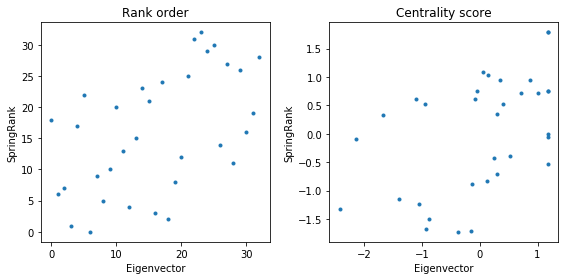

In [148]:
nodes = er_order.keys()
plt.figure(figsize=(8,4))
subplot(1,2,1)
plt.plot([er_order[v] for v in nodes], [sr_order[v] for v in nodes], '.')
title("Rank order"); xlabel("Eigenvector"); ylabel("SpringRank")
subplot(1,2,2)
plt.plot([er_rank[v] for v in nodes], [sr_rank[v] for v in nodes], '.')
title("Centrality score"); xlabel("Eigenvector"); ylabel("SpringRank")
plt.tight_layout()

### Analyze friendships

In [ ]:
bins = np.arange(min(rank_differences) - 0.5, max(rank_differences) + 0.5)
plt.hist(rank_differences, bins=bins)
xlabel("Rank difference"); ylabel("Count");
plt.tight_layout()

### Behavioral data

In [149]:
# Helper functions

def load_tfls_behavior():
    result = dict()
    t1 = []
    t2 = []
    t3 = []
    with open("external/s50_data/s50-alcohol.dat") as f:
        for row in f:
            a, b, c = re.split('\s+', row.strip())
            t1.append(float(a))
            t2.append(float(b))
            t3.append(float(c))
    result["alcohol"] = [t1, t2, t3]
    return result

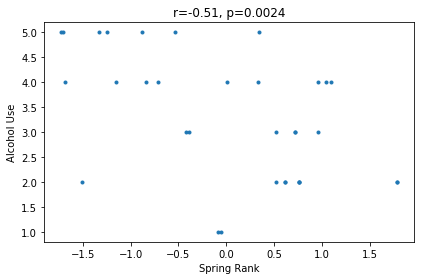

In [150]:
behavior = load_tfls_behavior()
nodes = sr_rank.keys()
x = [sr_rank[n] for n in nodes]
y = [behavior["alcohol"][1][n] for n in nodes]
plt.plot(x, y, '.')
r, p = spstats.pearsonr(x, y)
plt.title("r={:.2}, p={:.3}".format(r, p))
plt.xlabel("Spring Rank"); plt.ylabel("Alcohol Use");
plt.tight_layout()

## References
[BLN2013] De Bacco, C., Larremore, D. B., & Moore, C. (2017). A physical model for efficient ranking in networks. arXiv preprint arXiv:1709.09002.

[MA1997] L. Michell, and A. Amos, "Girls, pecking order and smoking." Social Science & Medicine 44(12), 1861-1869 (1997)

[KONECT2017] Facebook wall posts network dataset -- KONECT, April 2017.

[VMCG2009] Bimal Viswanath, Alan Mislove, Meeyoung Cha, and Krishna P. Gummadi. On the evolution of user interaction in Facebook. In Proc. Workshop on Online Social Networks, pages 37--42, 2009.